# Implementing a modern LeNet5

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## Load and prepare the MNIST dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)

In [3]:
# Normalize and reshape
X = X / 255.0
X = X.reshape(-1, 1, 28, 28)  # shape: (n_samples, channels, height, width)

In [4]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

In [5]:
# Convert to Pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [6]:
# Use dataloader to generate minibatches
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1000, shuffle=False)

## Define the modern LeNet-5 model

In [7]:
class ModernLeNet5(nn.Module):
    def __init__(self):
        super(ModernLeNet5, self).__init__()

        # Define a convolutional layer with 32 filters, 5x5 kernels. Adjust the
        # padding to maintain the height and width.
        # <answer>
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        # </answer>

        # Define a batch-normalization layer
        # <answer>
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # </answer>

        # Define a convolutional layer with 64 filters, 5x5 kernels. Adjust the
        # padding to maintain the height and width.
        # <answer>
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        # </answer>

        # Define a batch-normalization layer
        # <answer>
        self.bn2 = nn.BatchNorm2d(num_features=64)
        # </answer>

        # Define a max-pooling step
        # <answer>
        self.pool = nn.MaxPool2d(2, 2)
        # </answer>

        # Define a dropout layer with dropout rate 0.25
        # <answer>
        self.dropout = nn.Dropout(0.25)
        # </answer>

        # <answer>
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.bn3 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        # </answer>

    def forward(self, x):
        # Apply a first convolutional layer, a batch-normalization, an
        # activation function and a pooling
        # <answer>
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # </answer>

        # Same transformation again
        # <answer>
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # </answer>

        # Use fully connected later, batch-normalization, activation function,
        # dropout and final fully connected layer
        # <answer>
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.bn3(self.fc1(x))))
        x = self.fc2(x)
        # </answer>

        return x

## Training configuration

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModernLeNet5().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/home/sylvain/.local/lib/python3.13/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

## Train the model

In [9]:
epochs = 5
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Set gradients to zero, forward propagate, compute loss, backward
        # propagate and update parameters
        # <answer>
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # </answer>

        running_loss += loss.item()

    print(f"Epoch [{epoch}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5] - Loss: 0.0899
Epoch [2/5] - Loss: 0.0361
Epoch [3/5] - Loss: 0.0252
Epoch [4/5] - Loss: 0.0201
Epoch [5/5] - Loss: 0.0164

## Evaluate the model

In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Predict classes of `images`
        # <answer>
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # </answer>

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.10%

## Visualize predictions

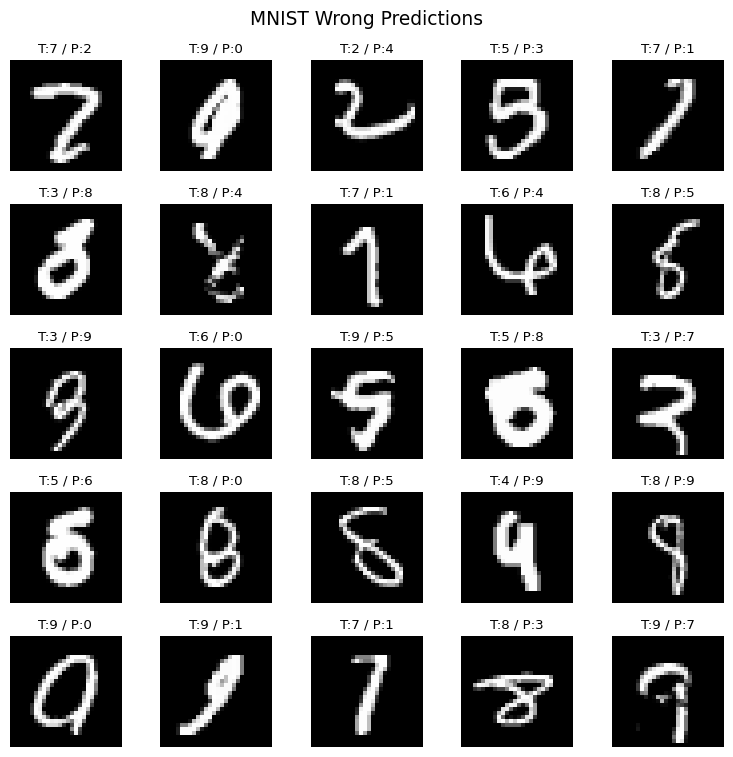

In [11]:
model.eval()
all_images, all_preds, all_labels = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_images.append(X_batch.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

# Stack all test data
X_all = np.concatenate(all_images)
y_all = np.concatenate(all_labels)
p_all = np.concatenate(all_preds)

# Find wrong predictions
wrong_idx = np.where(p_all != y_all)[0]

fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle("MNIST Wrong Predictions", fontsize=14)

for ax, idx in zip(axes.flat, wrong_idx):
    img = X_all[idx][0]
    true_label = y_all[idx]
    pred_label = p_all[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"T:{true_label} / P:{pred_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Bonus challenges

1.  Compute the fraction of total model parameters that belong to the
    classification head (i.e., the fully connected layers) in your
    current ModernLeNet5 architecture. Modify the model to replace the
    flattening step with a Global Average Pooling (GAP) layer before the
    classifier. What is the new fraction relative to the total parameter
    count?

2.  Are the bias terms in a convolutional layer necessary when the layer
    is immediately followed by a Batch Normalization layer?